In [1]:
import pandas as pd
import numpy as np
import sys
import re
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageChops, ImageOps

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler



Using TensorFlow backend.
/home/ec2-user/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
train_info = pd.read_csv('train_info.csv')
all_data_info = pd.read_csv('all_data_info.csv')

In [3]:
df = all_data_info.loc[all_data_info['artist'].isin(['John Singer Sargent', 'Edgar Degas', 'Giovanni Battista Piranesi', 'Claude Monet', 'Raphael Kirchner','Salvador Dali'])]

In [4]:
train = df[df['in_train']== True]
final_test = df[df['in_train']== False]

In [5]:
selected_jpgs = list(train.new_filename.values)

In [6]:
len(selected_jpgs)

2254

In [7]:
thumbs = '/home/ec2-user/GA/selected_artists_thumbs/'

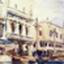

In [8]:
Image.open('/home/ec2-user/GA/selected_artists_thumbs/'+'209.jpg')

In [9]:
def get_array(jpg):
    pic = Image.open(thumbs+jpg)
    array = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1],3)
    return array

In [10]:
train_array = []
for i in selected_jpgs:
    train_array.append(get_array(i))

In [11]:
print(len(train_array))
print(len(train_array[0]))
print(len(train_array[0][0]))
print(len(train_array[0][0][0]))

2254
64
64
3


In [12]:
train_array_2d = np.reshape(train_array, (2254,12288))

### Pull in labels

In [13]:
train_df = pd.DataFrame(train_array_2d)

In [14]:
selected_jpgs_df = pd.DataFrame(selected_jpgs, columns=['jpg'])

In [15]:
selected_jpgs_df.tail()

,jpg
2249,95451.jpg
2250,38925.jpg
2251,39044.jpg
2252,65191.jpg
2253,46569.jpg


In [16]:
train_df = pd.concat([train_df, selected_jpgs_df], axis=1)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,jpg
0,99,81,67,97,79,65,95,77,63,96,...,65,61,52,64,60,51,63,59,50,95360.jpg
1,171,171,143,176,176,148,173,176,147,167,...,105,126,119,112,132,123,121,141,132,49757.jpg
2,227,227,227,234,234,234,238,238,238,239,...,235,235,235,220,220,220,222,222,222,96147.jpg
3,232,232,232,232,232,232,232,232,232,231,...,235,235,235,236,236,236,239,239,239,11889.jpg
4,107,107,107,116,116,116,105,105,105,119,...,104,104,104,131,131,131,182,182,182,856.jpg


In [17]:
artist_df = all_data_info[['new_filename', 'artist']]
artist_df.columns = ['jpg', 'artist']

In [18]:
train_df = pd.merge(train_df, artist_df, on='jpg', how='left')
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12280,12281,12282,12283,12284,12285,12286,12287,jpg,artist
0,99,81,67,97,79,65,95,77,63,96,...,61,52,64,60,51,63,59,50,95360.jpg,Edgar Degas
1,171,171,143,176,176,148,173,176,147,167,...,126,119,112,132,123,121,141,132,49757.jpg,Claude Monet
2,227,227,227,234,234,234,238,238,238,239,...,235,235,220,220,220,222,222,222,96147.jpg,Giovanni Battista Piranesi
3,232,232,232,232,232,232,232,232,232,231,...,235,235,236,236,236,239,239,239,11889.jpg,Giovanni Battista Piranesi
4,107,107,107,116,116,116,105,105,105,119,...,104,104,131,131,131,182,182,182,856.jpg,Giovanni Battista Piranesi


In [19]:
train_df.artist.value_counts()

Giovanni Battista Piranesi    402
Edgar Degas                   387
Claude Monet                  383
John Singer Sargent           377
Raphael Kirchner              357
Salvador Dali                 348
Name: artist, dtype: int64

### Train Test Split

In [20]:
X = train_df.iloc[:,:-2]
y = train_df.iloc[:,-1]

In [21]:
y = pd.get_dummies(y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
X_train = X_train/255.
X_test = X_test/255.

In [24]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1690, 12288)
(564, 12288)
(1690, 6)
(564, 6)


SVM variables

### CNN

In [25]:
#must reshape to grid for cnn

X_train = X_train.reshape(X_train.shape[0], 64, 64, 3)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 3)

Model 1

In [26]:
model = Sequential()
model.add(Conv2D((15), (5,5), input_shape=(64, 64, 3), activation='relu'))
#15 magnifine glasses, 5X5 is shape of magnifine glass
model.add(MaxPool2D(2,2))#2 pixel jump so no overlap on the scan, can use gridsearch to find best pixel slide
model.add(Conv2D(30, (4,4), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Train on 1690 samples, validate on 564 samples
Epoch 1/20
1690/1690 [==============================] - 7s 4ms/step - loss: 1.6749 - acc: 0.2864 - val_loss: 1.4454 - val_acc: 0.4007
Epoch 2/20
1690/1690 [==============================] - 7s 4ms/step - loss: 1.3840 - acc: 0.4698 - val_loss: 1.2022 - val_acc: 0.5656
Epoch 3/20
1690/1690 [==============================] - 7s 4ms/step - loss: 1.2825 - acc: 0.5249 - val_loss: 1.1386 - val_acc: 0.5957
Epoch 4/20
1690/1690 [==============================] - 7s 4ms/step - loss: 1.1808 - acc: 0.5598 - val_loss: 1.1097 - val_acc: 0.5993
Epoch 5/20
1690/1690 [==============================] - 7s 4ms/step - loss: 1.1143 - acc: 0.5899 - val_loss: 1.0842 - val_acc: 0.6046
Epoch 6/20
1690/1690 [==============================] - 7s 4ms/step - loss: 1.0613 - acc: 0.6083 - val_loss: 1.0885 - val_acc: 0.5975
Epoch 7/20
1690/1690 [==============================] - 7s 4ms/step - loss: 0.9891 - acc: 0.6408 - val_loss: 1.0014 - val_acc: 0.6330
Epoch 8/20
1690

In [28]:
model.evaluate(X_test, y_test)

564/564 [==============================] - 1s 1ms/step


[1.2434613281953419, 0.61702127659574468]

Model 2

In [26]:
model = Sequential()
model.add(Conv2D((15), (5,5), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Dropout(.5))
model.add(Conv2D(30, (4,4), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(800, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50)

Train on 1690 samples, validate on 564 samples
Epoch 1/50
1690/1690 [==============================] - 6s 4ms/step - loss: 1.8092 - acc: 0.1675 - val_loss: 1.7830 - val_acc: 0.1773
Epoch 2/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.7577 - acc: 0.2089 - val_loss: 1.7361 - val_acc: 0.2961
Epoch 3/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.6712 - acc: 0.2988 - val_loss: 1.5860 - val_acc: 0.3475
Epoch 4/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.5627 - acc: 0.3491 - val_loss: 1.5139 - val_acc: 0.4539
Epoch 5/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.4896 - acc: 0.4024 - val_loss: 1.4373 - val_acc: 0.4929
Epoch 6/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.4468 - acc: 0.4225 - val_loss: 1.3956 - val_acc: 0.4699
Epoch 7/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.4025 - acc: 0.4438 - val_loss: 1.3522 - val_acc: 0.4876
Epoch 8/50
1690

In [28]:
model.evaluate(X_train, y_train)

1690/1690 [==============================] - 2s 1ms/step


[0.84956068378933791, 0.67633136073513145]

Model 3

In [37]:
model = Sequential()
model.add(Conv2D((16), (5,5), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Dropout(.5))
model.add(Conv2D(30, (4,4), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(800, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50)

Train on 1690 samples, validate on 564 samples
Epoch 1/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.8222 - acc: 0.1710 - val_loss: 1.7908 - val_acc: 0.1862
Epoch 2/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.7817 - acc: 0.1876 - val_loss: 1.7834 - val_acc: 0.1560
Epoch 3/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.7576 - acc: 0.1982 - val_loss: 1.7546 - val_acc: 0.2181
Epoch 4/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.7142 - acc: 0.2396 - val_loss: 1.7116 - val_acc: 0.2518
Epoch 5/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.6930 - acc: 0.2793 - val_loss: 1.7177 - val_acc: 0.2571
Epoch 6/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.6782 - acc: 0.3189 - val_loss: 1.6659 - val_acc: 0.3174
Epoch 7/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.5671 - acc: 0.3621 - val_loss: 1.5430 - val_acc: 0.3706
Epoch 8/50
1690

In [39]:
model.evaluate(X_train, y_train)

1690/1690 [==============================] - 2s 1ms/step


[0.92391526579151495, 0.64082840257847806]

In [28]:
from keras.regularizers import l2 # L2-regularisation
l2_lambda = 0.001

### Model 2

In [32]:
model = Sequential()
model.add(Conv2D((16), (5,5), input_shape=(64, 64, 3), kernel_regularizer=l2(.01), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Dropout(.5))
model.add(Conv2D(30, (4,4), kernel_regularizer=l2(.01), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(800, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50)

Train on 1690 samples, validate on 564 samples
Epoch 1/50
1690/1690 [==============================] - 6s 3ms/step - loss: 2.0433 - acc: 0.1574 - val_loss: 1.9602 - val_acc: 0.2287
Epoch 2/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.9278 - acc: 0.1817 - val_loss: 1.8962 - val_acc: 0.2128
Epoch 3/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.8428 - acc: 0.2391 - val_loss: 1.7382 - val_acc: 0.3830
Epoch 4/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.7231 - acc: 0.3012 - val_loss: 1.6586 - val_acc: 0.3954
Epoch 5/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.6422 - acc: 0.3290 - val_loss: 1.5752 - val_acc: 0.4894
Epoch 6/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.5715 - acc: 0.3568 - val_loss: 1.4412 - val_acc: 0.5124
Epoch 7/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.4934 - acc: 0.4089 - val_loss: 1.3524 - val_acc: 0.5195
Epoch 8/50
1690

In [33]:
model.evaluate(X_train, y_train)

1690/1690 [==============================] - 2s 1ms/step


[1.1607800115495039, 0.56213017786748309]

In [34]:
#SAVE HERE
model.save('model4.h5')

In [58]:
#beat 70 vs 77 w .001, .01

### Model 1

In [114]:
model = Sequential()
model.add(Conv2D((15), (5,5), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPool2D(4,4)) 
model.add(Conv2D(20, (4,4), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Flatten())
model.add(Dense(600, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50)

Train on 1690 samples, validate on 564 samples
Epoch 1/50
1690/1690 [==============================] - 7s 4ms/step - loss: 1.7453 - acc: 0.2331 - val_loss: 1.5802 - val_acc: 0.4202
Epoch 2/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.5193 - acc: 0.3621 - val_loss: 1.4057 - val_acc: 0.4610
Epoch 3/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.4037 - acc: 0.4503 - val_loss: 1.2584 - val_acc: 0.5018
Epoch 4/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.3115 - acc: 0.4959 - val_loss: 1.1405 - val_acc: 0.5957
Epoch 5/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.2178 - acc: 0.5337 - val_loss: 1.0543 - val_acc: 0.6064
Epoch 6/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.1532 - acc: 0.5538 - val_loss: 1.0380 - val_acc: 0.6294
Epoch 7/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.0937 - acc: 0.5817 - val_loss: 1.0577 - val_acc: 0.6294
Epoch 8/50
1690

In [115]:
model.save('model1.h5')

### Model 3

In [26]:
model = Sequential()
model.add(Conv2D((15), (5,5), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPool2D(4,4)) 
model.add(Dropout(.5))
model.add(Conv2D(20, (4,4), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Flatten())
model.add(Dense(600, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50)

Train on 1690 samples, validate on 564 samples
Epoch 1/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.8101 - acc: 0.1941 - val_loss: 1.7821 - val_acc: 0.1773
Epoch 2/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.7531 - acc: 0.2426 - val_loss: 1.7496 - val_acc: 0.2801
Epoch 3/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.6459 - acc: 0.2988 - val_loss: 1.6797 - val_acc: 0.3032
Epoch 4/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.5485 - acc: 0.3698 - val_loss: 1.5185 - val_acc: 0.5319
Epoch 5/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.4751 - acc: 0.3964 - val_loss: 1.4013 - val_acc: 0.5390
Epoch 6/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.4344 - acc: 0.4231 - val_loss: 1.3643 - val_acc: 0.5691
Epoch 7/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.3863 - acc: 0.4355 - val_loss: 1.3217 - val_acc: 0.5656
Epoch 8/50
1690

In [28]:
model.evaluate(X_test, y_test)

564/564 [==============================] - 1s 1ms/step


[1.0219816823377676, 0.62234042553191493]

In [29]:
model.save('model3.h5')

### Model 3 - Binary

In [45]:
df_kirchner_piranesi = all_data_info.loc[all_data_info['artist'].isin(['Giovanni Battista Piranesi', 'Claude Monet'])]

In [46]:
train_kp = df_kirchner_piranesi[df_kirchner_piranesi['in_train']== True]
final_test_kp = df_kirchner_piranesi[df_kirchner_piranesi['in_train']== False]

kirchner_piranesi_jpgs = list(final_test_kp.new_filename.values)

In [47]:
train_df_kp = train_df[train_df['artist'].isin(['Giovanni Battista Piranesi', 'Raphael Kirchner'])]

In [48]:
train_df_kp.head()

,0,1,2,3,4,5,6,7,8,9,...,12280,12281,12282,12283,12284,12285,12286,12287,jpg,artist
2,227,227,227,234,234,234,238,238,238,239,...,235,235,220,220,220,222,222,222,96147.jpg,Giovanni Battista Piranesi
3,232,232,232,232,232,232,232,232,232,231,...,235,235,236,236,236,239,239,239,11889.jpg,Giovanni Battista Piranesi
4,107,107,107,116,116,116,105,105,105,119,...,104,104,131,131,131,182,182,182,856.jpg,Giovanni Battista Piranesi
5,202,202,202,206,206,206,209,209,209,209,...,181,181,192,192,192,187,187,187,67325.jpg,Giovanni Battista Piranesi
8,147,147,147,172,172,172,166,166,166,159,...,178,178,181,181,181,153,153,153,94943.jpg,Giovanni Battista Piranesi


In [49]:
X = train_df_kp.iloc[:,:-2]
y = train_df_kp.artist

In [50]:
y = pd.get_dummies(y)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [52]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [53]:
X_train = X_train.reshape(X_train.shape[0], 64, 64, 3)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 3)

In [54]:
model = Sequential()
model.add(Conv2D((15), (5,5), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPool2D(4,4)) 
model.add(Dropout(.5))
model.add(Conv2D(20, (4,4), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Flatten())
model.add(Dense(600, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50)

Train on 569 samples, validate on 190 samples
Epoch 1/50
569/569 [==============================] - 2s 4ms/step - loss: 7.5860 - acc: 0.5167 - val_loss: 9.0770 - val_acc: 0.4368
Epoch 2/50
569/569 [==============================] - 2s 3ms/step - loss: 8.0951 - acc: 0.4974 - val_loss: 9.0770 - val_acc: 0.4368
Epoch 3/50
569/569 [==============================] - 2s 3ms/step - loss: 8.2151 - acc: 0.4903 - val_loss: 9.0770 - val_acc: 0.4368
Epoch 4/50
569/569 [==============================] - 2s 3ms/step - loss: 8.2873 - acc: 0.4833 - val_loss: 9.0770 - val_acc: 0.4368
Epoch 5/50
569/569 [==============================] - 2s 3ms/step - loss: 8.3815 - acc: 0.4798 - val_loss: 9.0770 - val_acc: 0.4368
Epoch 6/50
569/569 [==============================] - 2s 3ms/step - loss: 7.8534 - acc: 0.5114 - val_loss: 9.0770 - val_acc: 0.4368
Epoch 7/50
569/569 [==============================] - 2s 3ms/step - loss: 8.1649 - acc: 0.4921 - val_loss: 9.0770 - val_acc: 0.4368
Epoch 8/50
569/569 [==========

### Model 6

In [29]:
model = Sequential()
model.add(Conv2D((15), (5,5), input_shape=(64, 64, 3), kernel_regularizer=l2(.001), activation='relu'))
model.add(MaxPool2D(4,4)) 
model.add(Dropout(.5))
model.add(Conv2D(20, (4,4), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Flatten())
model.add(Dense(600, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50)

Train on 1690 samples, validate on 564 samples
Epoch 1/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.7856 - acc: 0.1822 - val_loss: 1.7660 - val_acc: 0.2855
Epoch 2/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.7073 - acc: 0.2947 - val_loss: 1.6916 - val_acc: 0.3209
Epoch 3/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.6290 - acc: 0.3302 - val_loss: 1.6248 - val_acc: 0.3404
Epoch 4/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.5719 - acc: 0.3586 - val_loss: 1.5778 - val_acc: 0.3741
Epoch 5/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.5137 - acc: 0.3935 - val_loss: 1.5179 - val_acc: 0.4007
Epoch 6/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.4707 - acc: 0.4041 - val_loss: 1.4103 - val_acc: 0.4415
Epoch 7/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.4139 - acc: 0.4183 - val_loss: 1.3508 - val_acc: 0.4663
Epoch 8/50
1690

In [44]:
model.evaluate(X_test, y_test)

190/190 [==============================] - 0s 940us/step


[8.3135440424868943, 0.48421052757062411]

In [32]:
model.save('model6.h5')

### Model 7

In [47]:
model = Sequential()
model.add(Conv2D((15), (5,5), input_shape=(64, 64, 3), kernel_regularizer=l2(.001), activation='relu'))
model.add(MaxPool2D(4,4)) 
model.add(Dropout(.5))
model.add(Conv2D(20, (4,4), kernel_regularizer=l2(.0001), activation='relu'))
model.add(Conv2D(15, (4,4), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Flatten())
model.add(Dense(600, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50)

Train on 1690 samples, validate on 564 samples
Epoch 1/50
1690/1690 [==============================] - 6s 4ms/step - loss: 1.7966 - acc: 0.1876 - val_loss: 1.7872 - val_acc: 0.1897
Epoch 2/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.7491 - acc: 0.2479 - val_loss: 1.6909 - val_acc: 0.2890
Epoch 3/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.6639 - acc: 0.3036 - val_loss: 1.6013 - val_acc: 0.4096
Epoch 4/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.5931 - acc: 0.3550 - val_loss: 1.5155 - val_acc: 0.3865
Epoch 5/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.5142 - acc: 0.3935 - val_loss: 1.5315 - val_acc: 0.3599
Epoch 6/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.4483 - acc: 0.4243 - val_loss: 1.3384 - val_acc: 0.4770
Epoch 7/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.3849 - acc: 0.4408 - val_loss: 1.3254 - val_acc: 0.5018
Epoch 8/50
1690

In [51]:
model.evaluate(X_test, y_test)

564/564 [==============================] - 1s 1ms/step


[1.012179359053889, 0.62234042510918697]

In [52]:
model.save('model7.h5')

### Model 5

In [36]:
model = Sequential()
model.add(Conv2D((16), (5,5), input_shape=(64, 64, 3), kernel_regularizer=l2(.001), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Conv2D(30, (4,4), kernel_regularizer=l2(.01), activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Flatten())
model.add(Dense(800, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50)

Train on 1690 samples, validate on 564 samples
Epoch 1/50
1690/1690 [==============================] - 6s 3ms/step - loss: 1.8747 - acc: 0.2521 - val_loss: 1.6329 - val_acc: 0.4539
Epoch 2/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.6283 - acc: 0.3675 - val_loss: 1.4099 - val_acc: 0.4929
Epoch 3/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.4529 - acc: 0.4533 - val_loss: 1.3153 - val_acc: 0.5230
Epoch 4/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.3554 - acc: 0.5136 - val_loss: 1.2392 - val_acc: 0.5479
Epoch 5/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.3019 - acc: 0.5166 - val_loss: 1.2064 - val_acc: 0.5798
Epoch 6/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.2348 - acc: 0.5533 - val_loss: 1.0634 - val_acc: 0.6259
Epoch 7/50
1690/1690 [==============================] - 5s 3ms/step - loss: 1.1767 - acc: 0.5751 - val_loss: 1.1003 - val_acc: 0.6135
Epoch 8/50
1690

Model 2

In [37]:
model = Sequential()
model.add(Conv2D(12, kernel_size=(4,4), input_shape=(64,64,3), activation='relu'))
model.add(Conv2D(20, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D((4,4)))
model.add(Conv2D(20, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D((4,4)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Train on 1690 samples, validate on 564 samples
Epoch 1/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.7476 - acc: 0.2515 - val_loss: 1.6169 - val_acc: 0.3617
Epoch 2/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.4557 - acc: 0.4278 - val_loss: 1.3922 - val_acc: 0.4291
Epoch 3/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.2875 - acc: 0.4929 - val_loss: 1.2746 - val_acc: 0.5124
Epoch 4/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.2089 - acc: 0.5219 - val_loss: 1.1724 - val_acc: 0.5160
Epoch 5/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.1570 - acc: 0.5503 - val_loss: 1.1457 - val_acc: 0.5301
Epoch 6/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.1397 - acc: 0.5621 - val_loss: 1.1288 - val_acc: 0.5691
Epoch 7/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.1157 - acc: 0.5775 - val_loss: 1.1311 - val_acc: 0.5514
Epoch 8/

In [50]:
model = Sequential()
model.add(Conv2D(12, kernel_size=(4,4), input_shape=(64,64,3), activation='relu'))
model.add(Conv2D(20, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D((4,4)))
model.add(Conv2D(25, kernel_size=(5,5), activation='relu'))
model.add(Conv2D(20, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D((4,4)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Train on 1690 samples, validate on 564 samples
Epoch 1/20
1690/1690 [==============================] - 11s 7ms/step - loss: 1.7919 - acc: 0.1864 - val_loss: 1.7834 - val_acc: 0.1543
Epoch 2/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.6643 - acc: 0.2988 - val_loss: 1.4966 - val_acc: 0.3528
Epoch 3/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.4786 - acc: 0.3497 - val_loss: 1.4324 - val_acc: 0.3617
Epoch 4/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.4380 - acc: 0.3692 - val_loss: 1.4062 - val_acc: 0.4344
Epoch 5/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.3745 - acc: 0.4225 - val_loss: 1.3941 - val_acc: 0.4131
Epoch 6/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.3191 - acc: 0.4533 - val_loss: 1.2973 - val_acc: 0.4433
Epoch 7/20
1690/1690 [==============================] - 10s 6ms/step - loss: 1.3198 - acc: 0.4527 - val_loss: 1.2407 - val_acc: 0.4965
Epoch 8/

CNN with Randomized Search

In [77]:
def model_funk(input_shape=(64,64,3), layer_one_neurons=25, layer_two_neurons=20, 
               batch_size=50, kernel_size_one=(4,4), 
               kernel_size_two=(4,4)):
    model = Sequential()
    model.add(Conv2D(layer_one_neurons, kernel_size=kernel_size_one, input_shape=(64,64,3), activation='relu'))
    model.add(Conv2D(layer_two_neurons, kernel_size=kernel_size_two, activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(15, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [91]:
cnn_model = KerasClassifier(build_fn=model_funk, verbose=1, input_shape=(64,64,3), epochs=10)


params = {
    'kernel_size_one': [(4,4), (2,2)],
    'kernel_size_two': [(4,4), (2,2)],
}

rs = RandomizedSearchCV(cnn_model, param_distributions=params, n_iter=3)
rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

Epoch 1/10
1126/1126 [==============================] - 11s 10ms/step - loss: 1.7912 - acc: 0.1652
Epoch 2/10
1126/1126 [==============================] - 10s 9ms/step - loss: 1.7912 - acc: 0.1785
Epoch 3/10
1126/1126 [==============================] - 10s 9ms/step - loss: 1.7909 - acc: 0.1767
Epoch 4/10
1126/1126 [==============================] - 10s 9ms/step - loss: 1.7906 - acc: 0.1767
Epoch 5/10
1126/1126 [==============================] - 10s 9ms/step - loss: 1.7904 - acc: 0.1767
Epoch 6/10
1126/1126 [==============================] - 10s 9ms/step - loss: 1.7902 - acc: 0.1767
Epoch 7/10
1126/1126 [==============================] - 10s 9ms/step - loss: 1.7900 - acc: 0.1767
Epoch 8/10
1126/1126 [==============================] - 10s 9ms/step - loss: 1.7899 - acc: 0.1767
Epoch 9/10
1126/1126 [==============================] - 10s 9ms/step - loss: 1.7897 - acc: 0.1767
Epoch 10/10
1126/1126 [==============================] - 4s 4ms/step
Epoch 1/10
1127/1127 [==========================

In [54]:
def model_funk(input_shape=(64,64,3), layer_one_neurons=25, layer_two_neurons=20, 
               batch_size=50, max1=(4,4), max2=(4,4), dense1=10):
    model = Sequential()
    model.add(Conv2D(layer_one_neurons, kernel_size=(4,4), input_shape=(64,64,3), activation='relu'))
    model.add(Conv2D(layer_two_neurons, kernel_size=(4,4), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(15, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [55]:
cnn_model = KerasClassifier(build_fn=model_funk, verbose=1, input_shape=(64,64,3), epochs=10)


params = {
    'dense1': [16,18,20,22,24],
    'layer_one_neurons': [10,12,15,18],
    'layer_two_neurons': [10,12,16,20,25,28],

}

rs = RandomizedSearchCV(cnn_model, param_distributions=params, n_iter=3)
rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

Epoch 1/10
1126/1126 [==============================] - 5s 4ms/step - loss: 1.6995 - acc: 0.2575
Epoch 2/10
1126/1126 [==============================] - 5s 4ms/step - loss: 1.5679 - acc: 0.3677
Epoch 3/10
1126/1126 [==============================] - 5s 4ms/step - loss: 1.4894 - acc: 0.4361
Epoch 4/10
1126/1126 [==============================] - 5s 4ms/step - loss: 1.4519 - acc: 0.4609
Epoch 5/10
1126/1126 [==============================] - 5s 4ms/step - loss: 1.3897 - acc: 0.4849
Epoch 6/10
1126/1126 [==============================] - 5s 4ms/step - loss: 1.3514 - acc: 0.4920
Epoch 7/10
1126/1126 [==============================] - 5s 4ms/step - loss: 1.3607 - acc: 0.4831
Epoch 8/10
1126/1126 [==============================] - 5s 4ms/step - loss: 1.2620 - acc: 0.5293
Epoch 9/10
1126/1126 [==============================] - 5s 4ms/step - loss: 1.2107 - acc: 0.5631
Epoch 10/10
1126/1126 [==============================] - 2s 1ms/step
Epoch 1/10
1127/1127 [==============================] - 5s

Model with best params

In [98]:
model = Sequential()
model.add(Conv2D(15, kernel_size=(4,4), input_shape=(64,64,3), activation='relu'))
model.add(Conv2D(25, kernel_size=(4,4), activation='relu'))
model.add(MaxPool2D((4,4)))
model.add(Conv2D(15, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(6, activation='softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    

Model testing params

In [97]:
model = Sequential()
model.add(Conv2D(15, kernel_size=(4,4), input_shape=(64,64,3), activation='relu'))
model.add(Conv2D(20, kernel_size=(4,4), activation='relu'))
model.add(Conv2D(15, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D((4,4)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    